In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from umap import UMAP
import sys
sys.path.append('..')
from utils import load_pickle, save_pickle, seed_everything
seed_everything(42)

/home/sagawa/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
target_embedding = np.load("/data1/ReactionT5_neword/task_retrosynthesis/output_ord/embedding_mean.npy")
print(target_embedding.shape)

(1792472, 768)


In [3]:
sample_idx_target = np.random.choice(target_embedding.shape[0], 10000, replace=False)
target_embedding = target_embedding[sample_idx_target]

In [4]:
# umap = UMAP(n_components=2)
# target_embedding_umap = umap.fit_transform(target_embedding)

# save_pickle("/data1/ReactionT5_neword/task_retrosynthesis/output_ord/umap.pkl", umap)
# np.save("/data1/ReactionT5_neword/task_retrosynthesis/output_ord/embedding_umap.npy", target_embedding_umap)
target_embedding_umap = np.load("/data1/ReactionT5_neword/task_retrosynthesis/output_ord/embedding_umap.npy")
print(target_embedding_umap.shape)

(10000, 2)


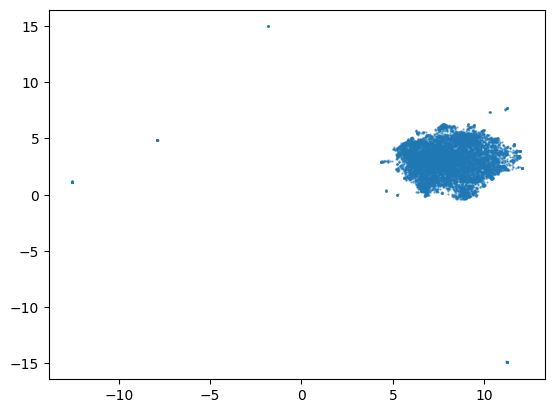

In [5]:
fig, ax = plt.subplots()
ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.5, s=0.5)

In [6]:
query_embedding = np.load("/data1/ReactionT5_neword/task_retrosynthesis/output_uspto_test/embedding_mean.npy")
print(query_embedding.shape)

(5004, 768)


In [7]:
# query_embedding_umap = umap.transform(query_embedding)
# np.save("/data1/ReactionT5_neword/task_retrosynthesis/output_uspto_test/query_embedding_umap.npy", query_embedding_umap)
query_embedding_umap = np.load("/data1/ReactionT5_neword/task_retrosynthesis/output_uspto_test/query_embedding_umap.npy")
print(query_embedding_umap.shape)

(5004, 2)


/tmp/ipykernel_385094/1249586914.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=12)
/tmp/ipykernel_385094/1249586914.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)


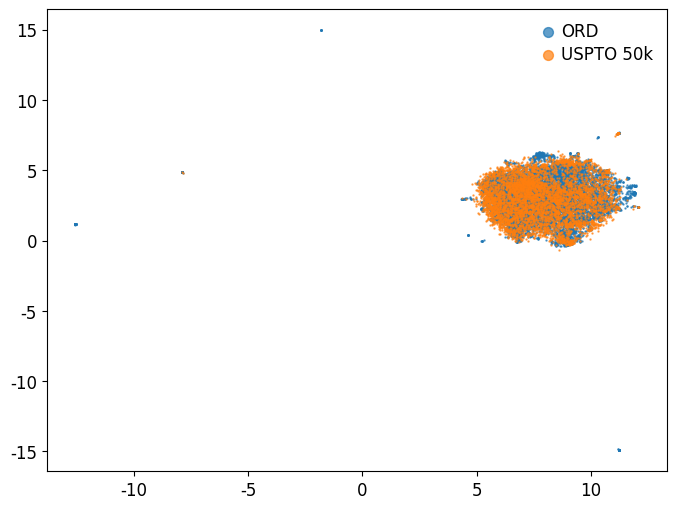

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.7, s=0.5, label="ORD")
ax.scatter(query_embedding_umap[:, 0], query_embedding_umap[:, 1], alpha=0.7, s=0.5, label="USPTO 50k")
# ax.set_xlabel("UMAP 1")
# ax.set_ylabel("UMAP 2")
ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=12)
ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)
# ax.set_xlim(7, 16)
# ax.set_ylim(0, 8)
ax.legend(  
    loc='upper right',
    fontsize=12,
    markerscale=10,
    frameon=False,
    labelspacing=0.3,
    borderpad=0.3,
    handletextpad=0.3,
    handlelength=1
)

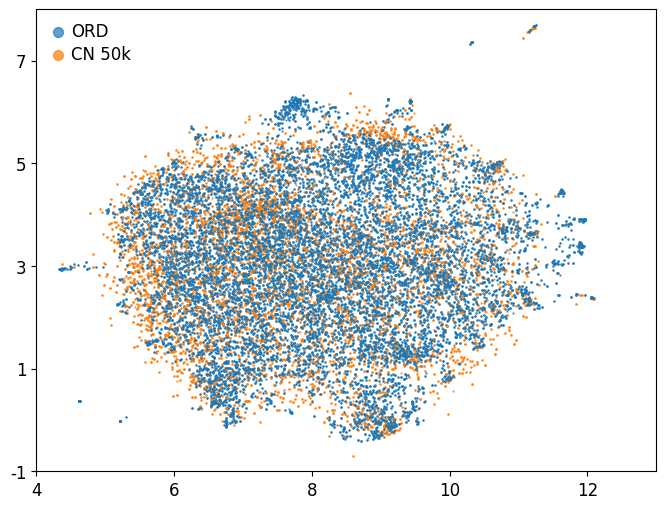

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.7, s=0.5, label="ORD")
# ax.scatter(query_embedding_umap[:, 0], query_embedding_umap[:, 1], alpha=0.7, s=0.5, label="USPTO 50k")
for i in range(0, 10000, 200):
    ax.scatter(target_embedding_umap[i:i+500, 0], target_embedding_umap[i:i+500, 1], alpha=0.7, s=0.5, label="ORD" if i == 0 else None, color="#1f77b4")
    ax.scatter(query_embedding_umap[i:i+500, 0], query_embedding_umap[i:i+500, 1], alpha=0.7, s=0.5, label="CN 50k" if i == 0 else None, color="#ff7f0e")
# ax.set_xlabel("UMAP 1")
# ax.set_ylabel("UMAP 2")
ax.set_xticks(range(4, 13, 2))
ax.set_yticks(range(-1, 9, 2))
ax.set_xticklabels(range(4, 13, 2), fontsize=12)
ax.set_yticklabels(range(-1, 9, 2), fontsize=12)
ax.set_xlim(4,13)
ax.set_ylim(-1, 8)
ax.legend(  
    loc='upper left',
    fontsize=12,
    markerscale=10,
    frameon=False,
    labelspacing=0.3,
    borderpad=0.3,
    handletextpad=0.3,
    handlelength=1
)

In [8]:
df_target = pd.read_csv("/data1/ReactionT5_neword/task_retrosynthesis/output_ord/input_data.csv")
df_target = df_target.iloc[sample_idx_target].reset_index(drop=True)
df_query = pd.read_csv("/data1/ReactionT5_neword/task_retrosynthesis/output_uspto_test/input_data.csv")

# df_target["input"] = df_target["input"].apply(lambda x: x.replace("REACTANT:", "").replace("REAGENT:", ".").replace(". ", ""))
# df_query["input"] = df_query["input"].apply(lambda x: x.replace("REACTANT:", "").replace("REAGENT:", ".").replace(". ", ""))

In [9]:
# calculate the molecular weight
from rdkit import Chem
from rdkit.Chem import Descriptors
# silence warning
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')
from transformers import AutoTokenizer 
tokenizer = AutoTokenizer.from_pretrained("sagawa/ReactionT5v2-retrosynthesis")

for df in [df_target, df_query]:
    df["mol"] = df["input"].apply(Chem.MolFromSmiles)
    df["mw"] = df["mol"].apply(Descriptors.MolWt)
    df["logp"] = df["mol"].apply(Descriptors.MolLogP)
    df["hba"] = df["mol"].apply(Descriptors.NumHAcceptors)
    df["hbd"] = df["mol"].apply(Descriptors.NumHDonors)
    df["tpsa"] = df["mol"].apply(Descriptors.TPSA)
    df["rotb"] = df["mol"].apply(Descriptors.NumRotatableBonds)
    df["atoms"] = df["mol"].apply(Descriptors.HeavyAtomCount)
    df["rings"] = df["mol"].apply(Descriptors.RingCount)
    df["qed"] = df["mol"].apply(Descriptors.qed)
    df["input_len"] = df["input"].apply(lambda x: len(tokenizer(x)["input_ids"]))

/home/sagawa/miniconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
# for each feature, clip with 5% and 95% percentile
features = ["mw", "logp", "hba", "hbd", "tpsa", "rotb", "atoms", "rings", "qed", "input_len"]
for feature in features:
    lower = df_target[feature].quantile(0.05)
    upper = df_target[feature].quantile(0.95)
    df_target[feature] = df_target[feature].clip(lower, upper)
    lower = df_query[feature].quantile(0.05)
    upper = df_query[feature].quantile(0.95)
    df_query[feature] = df_query[feature].clip(lower, upper)

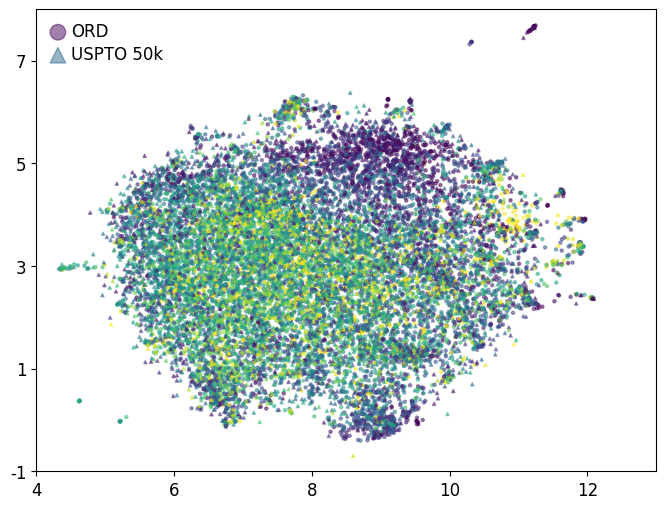

In [21]:
cmap = plt.get_cmap("viridis")
norm = plt.Normalize(min(df_target["mw"].min(), df_query["mw"].min()), max(df_target["mw"].max(), df_query["mw"].max()))
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    
ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.5, s=5, label="ORD", c=cmap(norm(df_target["mw"])), marker="o")
ax.scatter(query_embedding_umap[:, 0], query_embedding_umap[:, 1], alpha=0.5, s=5, label="USPTO 50k", c=cmap(norm(df_query["mw"])), marker="^")
# plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="Molecular Weight")
ax.set_xticks(range(4, 13, 2))
ax.set_yticks(range(-1, 9, 2))
ax.set_xticklabels(range(4, 13, 2), fontsize=12)
ax.set_yticklabels(range(-1, 9, 2), fontsize=12)
ax.set_xlim(4,13)
ax.set_ylim(-1, 8)
ax.legend(  
    loc='upper left',
    fontsize=12,
    markerscale=5,
    frameon=False,
    labelspacing=0.3,
    borderpad=0.3,
    handletextpad=0.3,
    handlelength=1
)

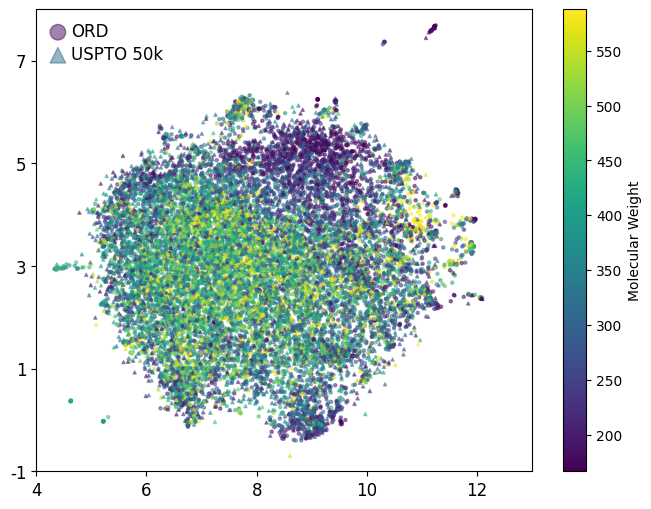

In [13]:
cmap = plt.get_cmap("viridis")
norm = plt.Normalize(min(df_target["mw"].min(), df_query["mw"].min()), max(df_target["mw"].max(), df_query["mw"].max()))
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    
ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.5, s=5, label="ORD", c=cmap(norm(df_target["mw"])), marker="o")
ax.scatter(query_embedding_umap[:, 0], query_embedding_umap[:, 1], alpha=0.5, s=5, label="USPTO 50k", c=cmap(norm(df_query["mw"])), marker="^")
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="Molecular Weight")
ax.set_xticks(range(4, 13, 2))
ax.set_yticks(range(-1, 9, 2))
ax.set_xticklabels(range(4, 13, 2), fontsize=12)
ax.set_yticklabels(range(-1, 9, 2), fontsize=12)
ax.set_xlim(4,13)
ax.set_ylim(-1, 8)
ax.legend(  
    loc='upper left',
    fontsize=12,
    markerscale=5,
    frameon=False,
    labelspacing=0.3,
    borderpad=0.3,
    handletextpad=0.3,
    handlelength=1
)

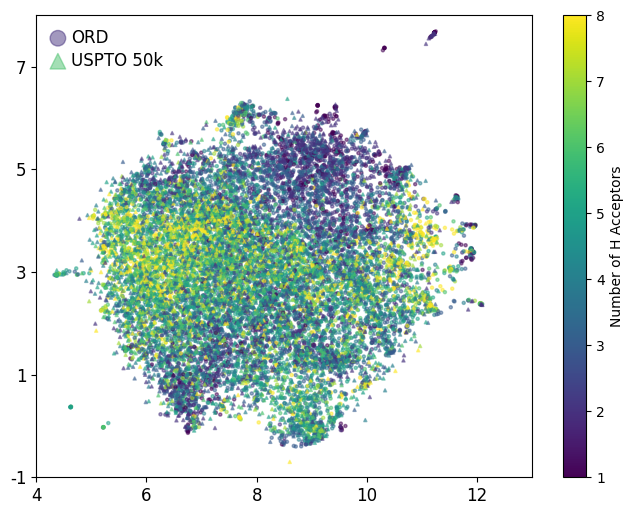

In [14]:
cmap = plt.get_cmap("viridis")
norm = plt.Normalize(min(df_target["hba"].min(), df_query["hba"].min()), max(df_target["hba"].max(), df_query["hba"].max()))
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    
ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.5, s=5, label="ORD", c=cmap(norm(df_target["hba"])), marker="o")
ax.scatter(query_embedding_umap[:, 0], query_embedding_umap[:, 1], alpha=0.5, s=5, label="USPTO 50k", c=cmap(norm(df_query["hba"])), marker="^")
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="Number of H Acceptors")
ax.set_xticks(range(4, 13, 2))
ax.set_yticks(range(-1, 9, 2))
ax.set_xticklabels(range(4, 13, 2), fontsize=12)
ax.set_yticklabels(range(-1, 9, 2), fontsize=12)
ax.set_xlim(4,13)
ax.set_ylim(-1, 8)
ax.legend(  
    loc='upper left',
    fontsize=12,
    markerscale=5,
    frameon=False,
    labelspacing=0.3,
    borderpad=0.3,
    handletextpad=0.3,
    handlelength=1
)

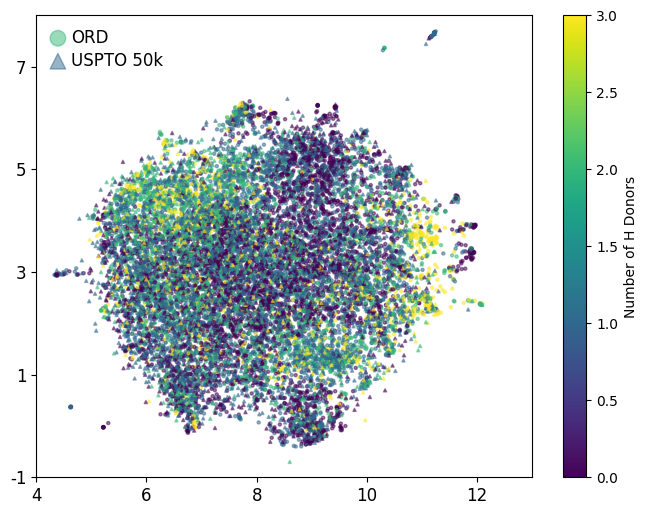

In [15]:
cmap = plt.get_cmap("viridis")
norm = plt.Normalize(min(df_target["hbd"].min(), df_query["hbd"].min()), max(df_target["hbd"].max(), df_query["hbd"].max()))
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    
ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.5, s=5, label="ORD", c=cmap(norm(df_target["hbd"])), marker="o")
ax.scatter(query_embedding_umap[:, 0], query_embedding_umap[:, 1], alpha=0.5, s=5, label="USPTO 50k", c=cmap(norm(df_query["hbd"])), marker="^")
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="Number of H Donors")
ax.set_xticks(range(4, 13, 2))
ax.set_yticks(range(-1, 9, 2))
ax.set_xticklabels(range(4, 13, 2), fontsize=12)
ax.set_yticklabels(range(-1, 9, 2), fontsize=12)
ax.set_xlim(4,13)
ax.set_ylim(-1, 8)
ax.legend(  
    loc='upper left',
    fontsize=12,
    markerscale=5,
    frameon=False,
    labelspacing=0.3,
    borderpad=0.3,
    handletextpad=0.3,
    handlelength=1
)

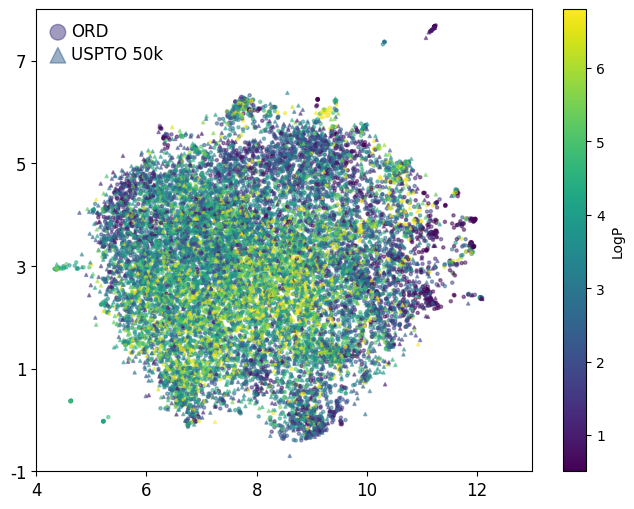

In [16]:
cmap = plt.get_cmap("viridis")
norm = plt.Normalize(min(df_target["logp"].min(), df_query["logp"].min()), max(df_target["logp"].max(), df_query["logp"].max()))
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    
ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.5, s=5, label="ORD", c=cmap(norm(df_target["logp"])), marker="o")
ax.scatter(query_embedding_umap[:, 0], query_embedding_umap[:, 1], alpha=0.5, s=5, label="USPTO 50k", c=cmap(norm(df_query["logp"])), marker="^")
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="LogP")
ax.set_xticks(range(4, 13, 2))
ax.set_yticks(range(-1, 9, 2))
ax.set_xticklabels(range(4, 13, 2), fontsize=12)
ax.set_yticklabels(range(-1, 9, 2), fontsize=12)
ax.set_xlim(4,13)
ax.set_ylim(-1, 8)
ax.legend(  
    loc='upper left',
    fontsize=12,
    markerscale=5,
    frameon=False,
    labelspacing=0.3,
    borderpad=0.3,
    handletextpad=0.3,
    handlelength=1
)

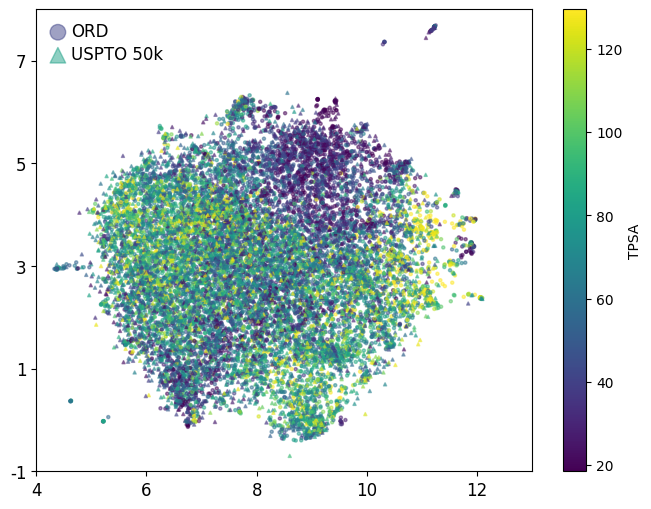

In [17]:
cmap = plt.get_cmap("viridis")
norm = plt.Normalize(min(df_target["tpsa"].min(), df_query["tpsa"].min()), max(df_target["tpsa"].max(), df_query["tpsa"].max()))
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    
ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.5, s=5, label="ORD", c=cmap(norm(df_target["tpsa"])), marker="o")
ax.scatter(query_embedding_umap[:, 0], query_embedding_umap[:, 1], alpha=0.5, s=5, label="USPTO 50k", c=cmap(norm(df_query["tpsa"])), marker="^")
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="TPSA")
ax.set_xticks(range(4, 13, 2))
ax.set_yticks(range(-1, 9, 2))
ax.set_xticklabels(range(4, 13, 2), fontsize=12)
ax.set_yticklabels(range(-1, 9, 2), fontsize=12)
ax.set_xlim(4,13)
ax.set_ylim(-1, 8)
ax.legend(  
    loc='upper left',
    fontsize=12,
    markerscale=5,
    frameon=False,
    labelspacing=0.3,
    borderpad=0.3,
    handletextpad=0.3,
    handlelength=1
)

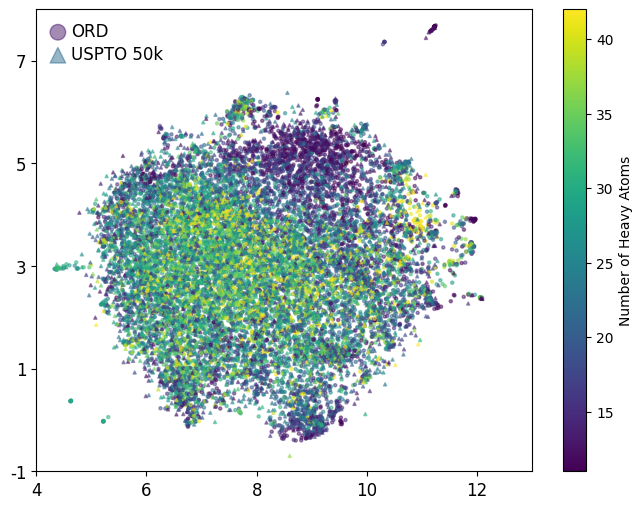

In [18]:
cmap = plt.get_cmap("viridis")
norm = plt.Normalize(min(df_target["atoms"].min(), df_query["atoms"].min()), max(df_target["atoms"].max(), df_query["atoms"].max()))
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    
ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.5, s=5, label="ORD", c=cmap(norm(df_target["atoms"])), marker="o")
ax.scatter(query_embedding_umap[:, 0], query_embedding_umap[:, 1], alpha=0.5, s=5, label="USPTO 50k", c=cmap(norm(df_query["atoms"])), marker="^")
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="Number of Heavy Atoms")
ax.set_xticks(range(4, 13, 2))
ax.set_yticks(range(-1, 9, 2))
ax.set_xticklabels(range(4, 13, 2), fontsize=12)
ax.set_yticklabels(range(-1, 9, 2), fontsize=12)
ax.set_xlim(4,13)
ax.set_ylim(-1, 8)
ax.legend(  
    loc='upper left',
    fontsize=12,
    markerscale=5,
    frameon=False,
    labelspacing=0.3,
    borderpad=0.3,
    handletextpad=0.3,
    handlelength=1
)

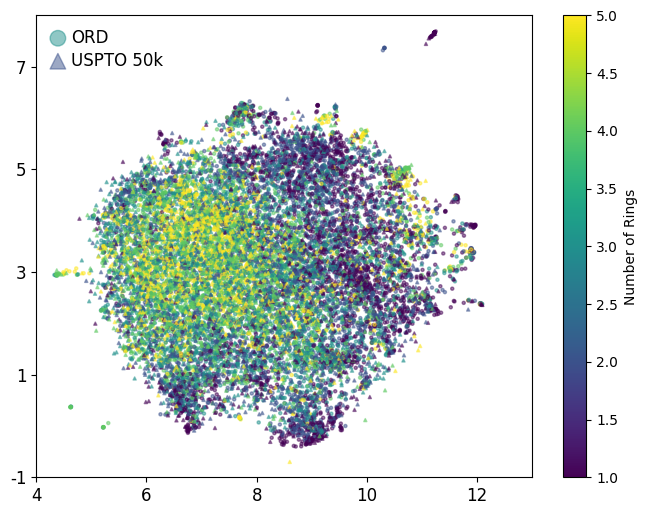

In [19]:
cmap = plt.get_cmap("viridis")
norm = plt.Normalize(min(df_target["rings"].min(), df_query["rings"].min()), max(df_target["rings"].max(), df_query["rings"].max()))
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    
ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.5, s=5, label="ORD", c=cmap(norm(df_target["rings"])), marker="o")
ax.scatter(query_embedding_umap[:, 0], query_embedding_umap[:, 1], alpha=0.5, s=5, label="USPTO 50k", c=cmap(norm(df_query["rings"])), marker="^")
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="Number of Rings")
ax.set_xticks(range(4, 13, 2))
ax.set_yticks(range(-1, 9, 2))
ax.set_xticklabels(range(4, 13, 2), fontsize=12)
ax.set_yticklabels(range(-1, 9, 2), fontsize=12)
ax.set_xlim(4,13)
ax.set_ylim(-1, 8)
ax.legend(  
    loc='upper left',
    fontsize=12,
    markerscale=5,
    frameon=False,
    labelspacing=0.3,
    borderpad=0.3,
    handletextpad=0.3,
    handlelength=1
)

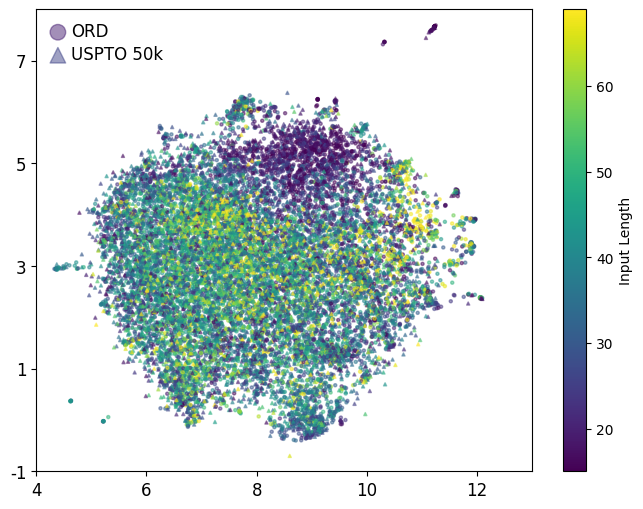

In [20]:
cmap = plt.get_cmap("viridis")
norm = plt.Normalize(min(df_target["input_len"].min(), df_query["input_len"].min()), max(df_target["input_len"].max(), df_query["input_len"].max()))
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    
ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.5, s=5, label="ORD", c=cmap(norm(df_target["input_len"])), marker="o")
ax.scatter(query_embedding_umap[:, 0], query_embedding_umap[:, 1], alpha=0.5, s=5, label="USPTO 50k", c=cmap(norm(df_query["input_len"])), marker="^")
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="Input Length")
ax.set_xticks(range(4, 13, 2))
ax.set_yticks(range(-1, 9, 2))
ax.set_xticklabels(range(4, 13, 2), fontsize=12)
ax.set_yticklabels(range(-1, 9, 2), fontsize=12)
ax.set_xlim(4,13)
ax.set_ylim(-1, 8)
ax.legend(  
    loc='upper left',
    fontsize=12,
    markerscale=5,
    frameon=False,
    labelspacing=0.3,
    borderpad=0.3,
    handletextpad=0.3,
    handlelength=1
)

# visualize distance

In [ ]:
distance = pd.read_csv("/data1/ReactionT5_neword/task_retrosynthesis/output_uspto_test/distance.csv")
distance

,REACTANT,PRODUCT,CATALYST,REAGENT,SOLVENT,input,distance
0,C1=COCCC1.COC(=O)CCC(=O)c1ccc(O)cc1O,COC(=O)CCC(=O)c1ccc(OC2CCCCO2)cc1O,,,,COC(=O)CCC(=O)c1ccc(OC2CCCCO2)cc1O,0.669855
1,COC(=O)c1cccc(C(=O)O)c1.Nc1cccnc1N,COC(=O)c1cccc(-c2nc3cccnc3[nH]2)c1,,,,COC(=O)c1cccc(-c2nc3cccnc3[nH]2)c1,0.723579
2,CC(C)(C)OC(=O)NC1CCC(C(=O)O)CC1.CNOC,CON(C)C(=O)C1CCC(NC(=O)OC(C)(C)C)CC1,,,,CON(C)C(=O)C1CCC(NC(=O)OC(C)(C)C)CC1,0.907065
3,Nc1ccc(O)cc1.O=[N+]([O-])c1ccc(Cl)nc1Cl,O=[N+]([O-])c1ccc(Cl)nc1Nc1ccc(O)cc1,,,,O=[N+]([O-])c1ccc(Cl)nc1Nc1ccc(O)cc1,0.791577
4,[N-]=[N+]=NCC1=CC[C@@H](c2ccc(Cl)cc2Cl)[C@H]([...,NCC1=CC[C@@H](c2ccc(Cl)cc2Cl)[C@H]([N+](=O)[O-...,,,,NCC1=CC[C@@H](c2ccc(Cl)cc2Cl)[C@H]([N+](=O)[O-...,0.768288
...,...,...,...,...,...,...,...
4999,Cc1cc([N+](=O)[O-])ccc1O.Nc1cc(Cl)ccn1,Cc1cc([N+](=O)[O-])ccc1Oc1ccnc(N)c1,,,,Cc1cc([N+](=O)[O-])ccc1Oc1ccnc(N)c1,0.884089
5000,COC(=O)c1[nH]c2cc(Cl)cc3c2c1C(CC(=O)OC(C)(C)C)CC3,COC(=O)c1[nH]c2cc(Cl)cc3c2c1C(CC(=O)O)CC3,,,,COC(=O)c1[nH]c2cc(Cl)cc3c2c1C(CC(=O)O)CC3,0.646120
5001,COc1cc(C(F)(F)F)cc(SC)c1C(=O)NC1(c2ccccc2)CC(=...,COc1cc(C(F)(F)F)cc(SC)c1C(=O)NC1(c2ccccc2)CC(O...,,,,COc1cc(C(F)(F)F)cc(SC)c1C(=O)NC1(c2ccccc2)CC(O...,0.830466
5002,C=C(C)Cn1nc(C)c(Br)c1-c1ccc(F)cc1.OO,Cc1nn(CC(C)CO)c(-c2ccc(F)cc2)c1Br,,,,Cc1nn(CC(C)CO)c(-c2ccc(F)cc2)c1Br,0.692978


/tmp/ipykernel_3436725/97392767.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)


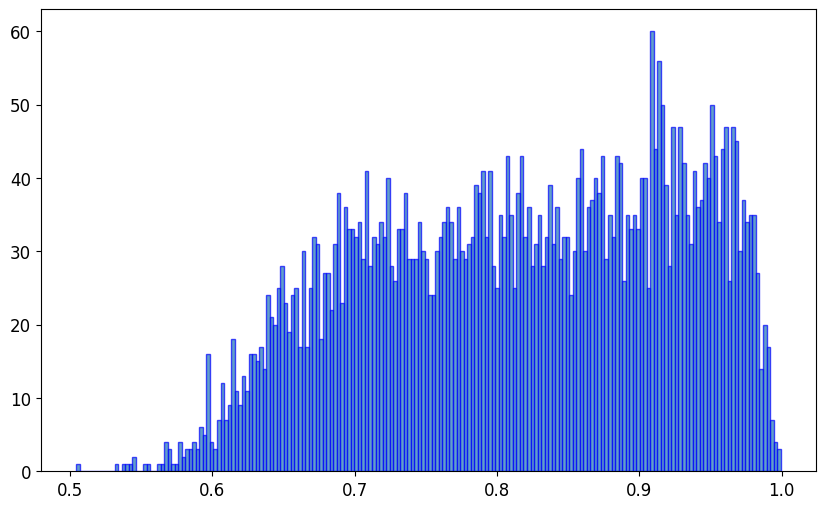

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
distance["distance"].hist(bins=200, ax=ax, edgecolor="b", alpha=0.7)
ax.set_xticks(np.arange(0.5, 1.05, 0.1))
ax.set_xticklabels([0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize=12)
ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)
ax.grid(axis="y", alpha=0)
ax.grid(axis="x", alpha=0)

# visualize distance

In [43]:
distance = pd.read_csv("/data1/ReactionT5_neword/task_retrosynthesis/output_uspto_test/distance.csv")
distance

,REACTANT,PRODUCT,CATALYST,REAGENT,SOLVENT,input,distance
0,C1=COCCC1.COC(=O)CCC(=O)c1ccc(O)cc1O,COC(=O)CCC(=O)c1ccc(OC2CCCCO2)cc1O,,,,COC(=O)CCC(=O)c1ccc(OC2CCCCO2)cc1O,0.669855
1,COC(=O)c1cccc(C(=O)O)c1.Nc1cccnc1N,COC(=O)c1cccc(-c2nc3cccnc3[nH]2)c1,,,,COC(=O)c1cccc(-c2nc3cccnc3[nH]2)c1,0.723579
2,CC(C)(C)OC(=O)NC1CCC(C(=O)O)CC1.CNOC,CON(C)C(=O)C1CCC(NC(=O)OC(C)(C)C)CC1,,,,CON(C)C(=O)C1CCC(NC(=O)OC(C)(C)C)CC1,0.907065
3,Nc1ccc(O)cc1.O=[N+]([O-])c1ccc(Cl)nc1Cl,O=[N+]([O-])c1ccc(Cl)nc1Nc1ccc(O)cc1,,,,O=[N+]([O-])c1ccc(Cl)nc1Nc1ccc(O)cc1,0.791577
4,[N-]=[N+]=NCC1=CC[C@@H](c2ccc(Cl)cc2Cl)[C@H]([...,NCC1=CC[C@@H](c2ccc(Cl)cc2Cl)[C@H]([N+](=O)[O-...,,,,NCC1=CC[C@@H](c2ccc(Cl)cc2Cl)[C@H]([N+](=O)[O-...,0.768288
...,...,...,...,...,...,...,...
4999,Cc1cc([N+](=O)[O-])ccc1O.Nc1cc(Cl)ccn1,Cc1cc([N+](=O)[O-])ccc1Oc1ccnc(N)c1,,,,Cc1cc([N+](=O)[O-])ccc1Oc1ccnc(N)c1,0.884089
5000,COC(=O)c1[nH]c2cc(Cl)cc3c2c1C(CC(=O)OC(C)(C)C)CC3,COC(=O)c1[nH]c2cc(Cl)cc3c2c1C(CC(=O)O)CC3,,,,COC(=O)c1[nH]c2cc(Cl)cc3c2c1C(CC(=O)O)CC3,0.646120
5001,COc1cc(C(F)(F)F)cc(SC)c1C(=O)NC1(c2ccccc2)CC(=...,COc1cc(C(F)(F)F)cc(SC)c1C(=O)NC1(c2ccccc2)CC(O...,,,,COc1cc(C(F)(F)F)cc(SC)c1C(=O)NC1(c2ccccc2)CC(O...,0.830466
5002,C=C(C)Cn1nc(C)c(Br)c1-c1ccc(F)cc1.OO,Cc1nn(CC(C)CO)c(-c2ccc(F)cc2)c1Br,,,,Cc1nn(CC(C)CO)c(-c2ccc(F)cc2)c1Br,0.692978


/tmp/ipykernel_3436725/97392767.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)


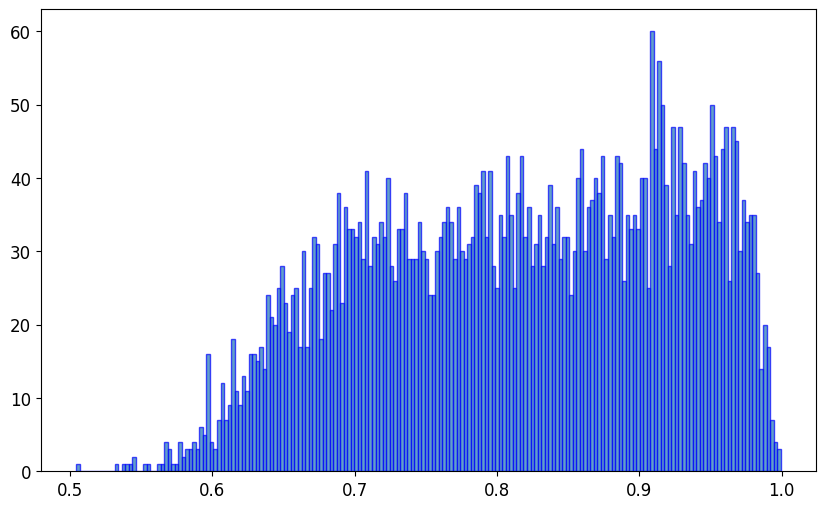

In [59]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
distance["distance"].hist(bins=200, ax=ax, edgecolor="b", alpha=0.7)
ax.set_xticks(np.arange(0.5, 1.05, 0.1))
ax.set_xticklabels([0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize=12)
ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)
ax.grid(axis="y", alpha=0)
ax.grid(axis="x", alpha=0)

In [45]:
print(len(pd.read_csv("/data1/ReactionT5_neword/task_retrosynthesis/output_uspto_test/top1_similar_reactions.csv")))
print(len(pd.read_csv("/data1/ReactionT5_neword/task_retrosynthesis/output_uspto_test/top3_similar_reactions.csv")))
print(len(pd.read_csv("/data1/ReactionT5_neword/task_retrosynthesis/output_uspto_test/top5_similar_reactions.csv")))


4942
14758
24445


3393

In [3]:
target_embedding = np.load("/data1/ReactionT5_neword/task_retrosynthesis/output_ord/embedding_mean.npy")
umap = UMAP(n_components=2)
target_embedding_umap = umap.fit_transform(target_embedding)

save_pickle("/data1/ReactionT5_neword/task_retrosynthesis/output_ord/umap_full.pkl", umap)
np.save("/data1/ReactionT5_neword/task_retrosynthesis/output_ord/embedding_umap_full.npy", target_embedding_umap)

query_embedding = np.load("/data1/ReactionT5_neword/task_retrosynthesis/output_uspto_test/embedding_mean.npy")
query_embedding_umap = umap.transform(query_embedding)
np.save("/data1/ReactionT5_neword/task_retrosynthesis/output_uspto_test/query_embedding_umap_full.npy", query_embedding_umap)

/home/sagawa/miniconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:411: UserWarning: Exited at iteration 369 with accuracies 
[8.43308434e-15 1.22499990e-04 1.11821524e-04 8.41658827e-05]
not reaching the requested tolerance 8.48621129989624e-05.
Use iteration 325 instead with accuracy 
7.115058487540684e-05.

  _, diffusion_map = lobpcg(
/home/sagawa/miniconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:411: UserWarning: Exited postprocessing with accuracies 
[6.08115114e-15 8.36343019e-05 1.00718684e-04 1.00249353e-04]
not reaching the requested tolerance 8.48621129989624e-05.
  _, diffusion_map = lobpcg(
/home/sagawa/miniconda3/lib/python3.11/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/sagawa/miniconda3/lib/python3.11

In [2]:
df_target = pd.read_csv("/data1/ReactionT5_neword/task_retrosynthesis/output_ord/input_data.csv")
df_query = pd.read_csv("/data1/ReactionT5_neword/task_retrosynthesis/output_uspto_test/input_data.csv")


from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
# silence warning
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')

target_fp = []
query_fp = []
for smiles in df_target["input"]:
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024)
    target_fp.append(fp)
for smiles in df_query["input"]:
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024)
    query_fp.append(fp)

In [3]:
from rdkit import DataStructs
similarity_score = [0 for _ in range(len(query_fp))]
for i, query in enumerate(query_fp):
    scores = []
    for j, target in enumerate(target_fp):
        scores.append(DataStructs.TanimotoSimilarity(query, target))
    # store the index of the most similar target
    similarity_score[i] = np.argmax(scores)

similarity_score = np.array(similarity_score)
np.save("/data1/ReactionT5_neword/task_retrosynthesis/output_uspto_test/similar_reactions_index_morgan_tanimoto.npy", similarity_score)

In [5]:
target_embedding_umap = np.load("/data1/ReactionT5_neword/task_retrosynthesis/output_ord/embedding_umap_full.npy")
query_embedding_umap = np.load("/data1/ReactionT5_neword/task_retrosynthesis/output_uspto_test/query_embedding_umap_full.npy")

similar_reactions = []
for i in range(len(query_embedding_umap)):
    mse_distance = []
    for j in range(len(target_embedding_umap)):
        mse_distance.append(np.linalg.norm(query_embedding_umap[i] - target_embedding_umap[j]))
    similar_reactions.append(np.argmin(mse_distance))

similar_reactions = np.array(similar_reactions)
np.save("/data1/ReactionT5_neword/task_retrosynthesis/output_uspto_test/similar_reactions_index_ReactionT5.npy", similar_reactions)

In [15]:
import Levenshtein
similar_reactions = np.load("/data1/ReactionT5_neword/task_retrosynthesis/output_uspto_test/similar_reactions_index_morgan_tanimoto.npy")
df_similar = df_target.iloc[similar_reactions].reset_index(drop=True)
print(len(df_similar), len(df_query))

5004 5004


Mean: 12.815347721822542 Std: 12.565856741761353 Max: 102 Min: 1 Median: 8.0 25%: 3.0 75%: 19.0


/tmp/ipykernel_1310585/2491858436.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=16)
/tmp/ipykernel_1310585/2491858436.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=16)


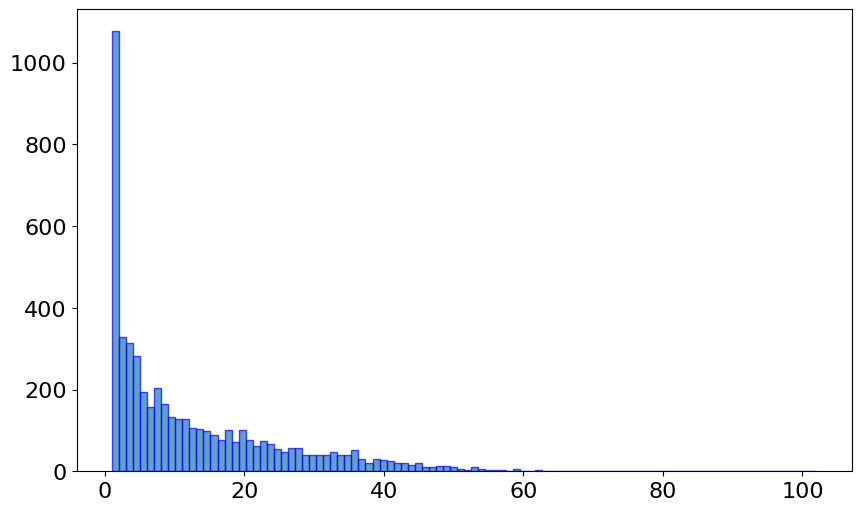

In [16]:
distances = []
for i in range(len(df_query)):
    distances.append(Levenshtein.distance(df_query["input"][i], df_similar["input"][i]))
distances = np.array(distances)
# print statistics
print("Mean:", distances.mean(), "Std:", distances.std(), "Max:", distances.max(), "Min:", distances.min(), "Median:", np.median(distances), "25%:", np.percentile(distances, 25), "75%:", np.percentile(distances, 75))
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(distances, bins=100 ,edgecolor="b", alpha=0.7)
ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=16)
ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=16)
ax.grid(axis="y", alpha=0)
ax.grid(axis="x", alpha=0)

5004 5004
Mean: 30.237210231814547 Std: 18.122503860505258 Max: 138 Min: 1 Median: 30.0 25%: 16.0 75%: 42.0


/tmp/ipykernel_1310585/626040076.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=16)
/tmp/ipykernel_1310585/626040076.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=16)


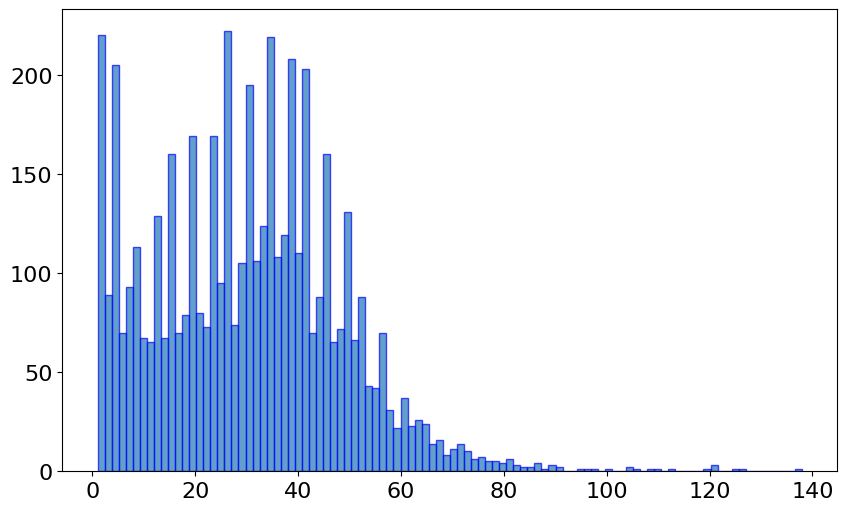

In [17]:
similar_reactions = np.load("/data1/ReactionT5_neword/task_retrosynthesis/output_uspto_test/similar_reactions_index_ReactionT5.npy")
df_similar = df_target.iloc[similar_reactions].reset_index(drop=True)
print(len(df_similar), len(df_query))
distances = []
for i in range(len(df_query)):
    distances.append(Levenshtein.distance(df_query["input"][i], df_similar["input"][i]))
distances = np.array(distances)
print("Mean:", distances.mean(), "Std:", distances.std(), "Max:", distances.max(), "Min:", distances.min(), "Median:", np.median(distances), "25%:", np.percentile(distances, 25), "75%:", np.percentile(distances, 75))
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(distances, bins=100 ,edgecolor="b", alpha=0.7)
ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=16)
ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=16)
ax.grid(axis="y", alpha=0)
ax.grid(axis="x", alpha=0)